# Angle-based Joint and Individual Variation Explained

This notebook deomonstrations some of the Angle-based Joint and Individual Variation Explained (AJIVE) functionality. The notebook assumes the reader has knowledge of AJIVE and is looking to understand the basic functionality of this particular python implementaion.

It may be helpful to familiar with conventions explained in [PCA_demo.ipynb](https://github.com/idc9/py_jive/blob/master/doc/PCA_demo.ipynb).

In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from jive.AJIVE import AJIVE
from jive.PCA import PCA
from jive.ajive_fig2 import generate_data_ajive_fig2
from jive.viz.block_visualization import data_block_heatmaps, jive_full_estimate_heatmaps
from mvlearn.datasets.base import load_UCImultifeature
from sklearn.datasets import make_blobs



In [14]:
p = np.array([100,100,100,100,100,100])

#creates the blobs
j = make_blobs(n_features=12,n_samples=p, cluster_std= 4,random_state= 1)
k = make_blobs(n_features = 27,n_samples = p,cluster_std = 3,random_state=23)
l = make_blobs(n_features = 22,n_samples = p,cluster_std = 5,random_state=35)
m = make_blobs(n_features = 32,n_samples = p,cluster_std = 5,random_state=52)
n = make_blobs(n_features = 15,n_samples = p,cluster_std = 7,random_state=2)


v1 = j[0]
v2 = k[0]
v3 = l[0]
v4 = m[0]
v5 = n[0]

Views = [v1,v2,v3,v4,v5]

# Generate some toy, two block data

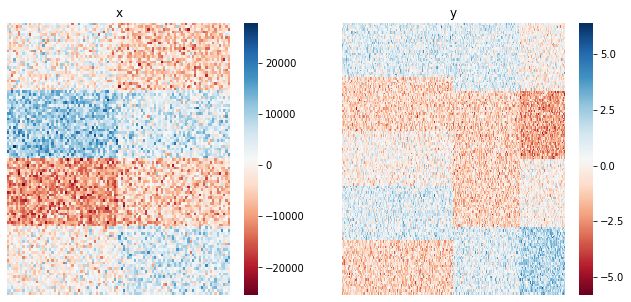

In [4]:
X, Y = generate_data_ajive_fig2()

plt.figure(figsize=[11,  5])
data_block_heatmaps({'x': X, 'y': Y})

# Run AJIVE

### 1. Estimate initial signal rank using scree plots

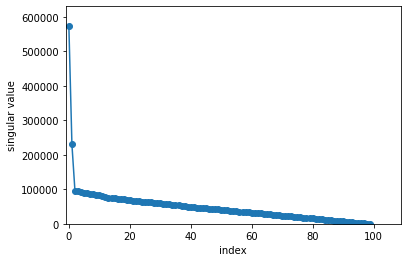

In [3]:
# based on this scree plot, we set the initial signal rank for the X block to 2
PCA().fit(X).plot_scree()

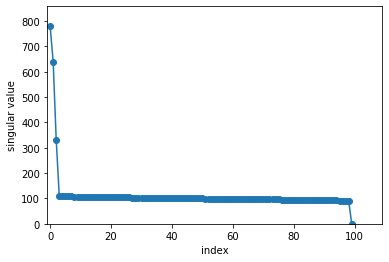

In [4]:
# based on this scree plot, we set the initial signal rank for the X block to 3
PCA().fit(Y).plot_scree()

### Run  AJIVE procedure

The only required parameter is `init_signal_ranks`. Note AJIVE will mean center the columns by default!

In [5]:
ajive = AJIVE(init_signal_ranks={'x': 2, 'y': 3})
ajive.fit(blocks=[X,Y])

# passing the arguments in a lists also works
# ajive = AJIVE(init_signal_ranks=[2, 3])
# ajive.fit(blocks=[X, Y])

AJIVE, joint rank: 1, block x indiv rank: 1, block y indiv rank: 2

# Results

Below are some of the data jive computes by default

- `jive.common` stores the common joint information (e.g. common joint scores)
- `jive.blocks`[**BLOCKNAME**`].joint` stores the block specific joint information for block **BLOCKNAME**
- `jive.blocks[`**BLOCKNAME**`].individual` stores the block specific individual information for block **BLOCKNAME**

Note that each of these are `jive.PCA.PCA` objects. See the PCA_demo.ipynb notebook and the `jive.PCA.PCA` documentaiton for further explaination.

In [6]:
print('joint rank:', ajive.common.rank)
ajive.common.scores()

joint rank: 1


common_comp_0
0        0.102439
1        0.106741
2        0.101450
3        0.095431
4        0.090191
..            ...
95      -0.102937
96      -0.107525
97      -0.100503
98      -0.098634
99      -0.100209

[100 rows x 1 columns]

In [7]:
print('y block individual rank:', ajive.blocks['y'].individual.rank)
ajive.blocks['y'].individual.loadings()

y block individual rank: 2


indiv_comp_0  indiv_comp_1
0         0.000298     -0.010583
1         0.002541     -0.015407
2        -0.000074     -0.016125
3        -0.001453     -0.013561
4        -0.001257     -0.014880
...            ...           ...
9995      0.016085     -0.001732
9996      0.011901      0.001327
9997      0.017797     -0.000326
9998      0.016641      0.001741
9999      0.012014     -0.000076

[10000 rows x 2 columns]

In [8]:
# the full joint, individual and noise matrices are available as follows
print(ajive.blocks['y'].joint.full_.shape)
print(ajive.blocks['y'].individual.full_.shape)
print(ajive.blocks['y'].noise_.shape)

(100, 10000)
(100, 10000)
(100, 10000)


### heatmaps of full estimates

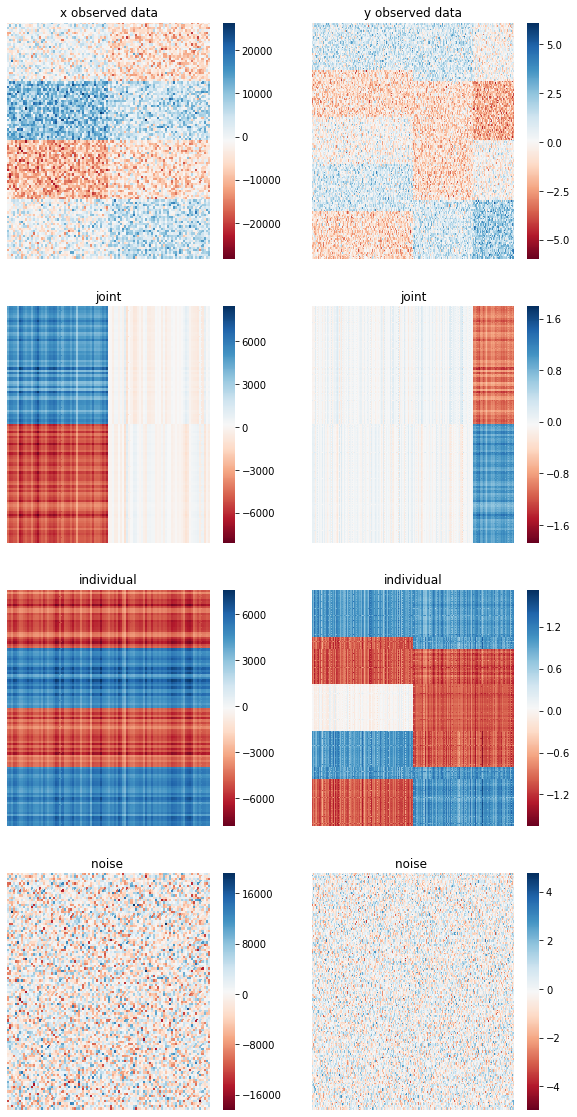

In [9]:
plt.figure(figsize=[10, 20])
jive_full_estimate_heatmaps(ajive.get_full_block_estimates(), blocks={'x':X, 'y': Y})

### Visualize joint and individual modes of variation

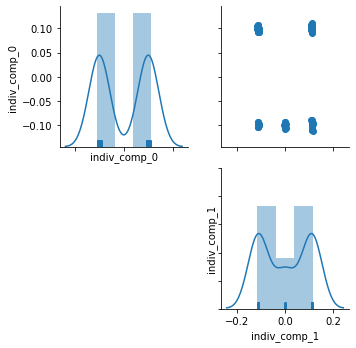

In [10]:
# Notice there are distinct clusters in the second block's individual scores
ajive.blocks['y'].individual.plot_scores()

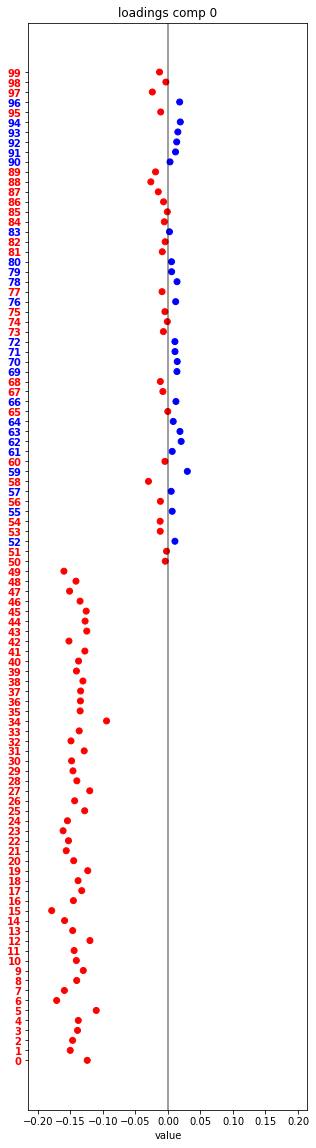

In [11]:
# notice the first joint loadings component seems 
# to be driven by variables 0-50 (which it should!)
plt.figure(figsize=[5, 20])
ajive.blocks['x'].joint.plot_loading(comp=0, abs_sorted=False)

# User can specify joint and/or individual ranks

In [12]:
AJIVE(init_signal_ranks=[2, 3], joint_rank=4, reconsider_joint_components=False).fit(blocks=[X, Y])

AJIVE, joint rank: 4, block 0 indiv rank: 0, block 1 indiv rank: 0

In [13]:
AJIVE(init_signal_ranks=[2, 3], indiv_ranks=[2, 2], reconsider_joint_components=False).fit(blocks=[X, Y])

AJIVE, joint rank: 1, block 0 indiv rank: 2, block 1 indiv rank: 2

In [14]:
AJIVE(init_signal_ranks=[2, 3], joint_rank=2, indiv_ranks=[2, 2], reconsider_joint_components=False).fit(blocks=[X, Y])

AJIVE, joint rank: 2, block 0 indiv rank: 2, block 1 indiv rank: 2

# Precomputed data
The hard computations in AJIVE are

- low rank initial block SVDs
- wedin samples
- random direction bound smaples

The user may precompute these on their own (e.g. using a computing cluster). 

### Precomputed SVD

For each block, the precomputed SVD has to be provided as a tuple (scores, svals, loadings) or as a dict whose keys are ['scores', 'svals', 'loadings'].

In [15]:
# precomputed the X blocks SVD
# be careful to center the same way as AJIVE!

x_init_svd = PCA().fit(X).get_UDV()  # pca = mean center then SVD
# x_init_svd = {'scores': x_init_svd[0], 'svals': x_init_svd[1], 'loadings': x_init_svd[2]} # also works

y_init_svd = None

ajive = AJIVE(init_signal_ranks={'x': 2, 'y': 3})
ajive.fit(blocks={'x': X, 'y': Y}, precomp_init_svd={'x': x_init_svd, 'y': y_init_svd})

AJIVE, joint rank: 1, block x indiv rank: 1, block y indiv rank: 2